In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.utils import shuffle
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Paths and data
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True, mmap_mode='r')
nonmutated_data = np.load("/content/EAUGMENTED_DATA_TRAINING_6000.npz", allow_pickle=True, mmap_mode='r')
csv_file = "cry1realvariations (1).csv"  # CSV with mutation data

# Load sequences function
def load_sequences(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:  # If 2D, reshape to 3D for LSTM
            temp_sequences = np.expand_dims(temp_sequences, axis=1)  # (samples, 1, features)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            input_shape = input_shape=(encoded_sequences.shape[1], encoded_sequences.shape[2])
            break
    return encoded_sequences, input_shape

# Load mutated and non-mutated sequences
mutated_sequences, shape = load_sequences(mutated_data)
nonmutated_sequences, shape = load_sequences(nonmutated_data)

# Labels
mutated_labels = np.ones(mutated_sequences.shape[0])  # 1 for mutated
nonmutated_labels = np.zeros(nonmutated_sequences.shape[0])  # 0 for non-mutated

# Step 1: Split data into train, validation, and test sets
X_mutated_train, X_mutated_temp, y_mutated_train, y_mutated_temp = train_test_split(
    mutated_sequences, mutated_labels, test_size=0.25, random_state=42)  # 60% train, 40% temp
X_nonmutated_train, X_nonmutated_temp, y_nonmutated_train, y_nonmutated_temp = train_test_split(
    nonmutated_sequences, nonmutated_labels, test_size=0.25, random_state=42)  # 60% train, 40% temp

# Split temp into validation and test sets (50% validation, 50% test)
X_mutated_val, X_mutated_test, y_mutated_val, y_mutated_test = train_test_split(
    X_mutated_temp, y_mutated_temp, test_size=0.5, random_state=42)  # 50% validation, 50% test
X_nonmutated_val, X_nonmutated_test, y_nonmutated_val, y_nonmutated_test = train_test_split(
    X_nonmutated_temp, y_nonmutated_temp, test_size=0.5, random_state=42)  # 50% validation, 50% test

# Combine mutated and non-mutated data for training, validation, and testing
X_train = np.concatenate([X_mutated_train, X_nonmutated_train], axis=0)
y_train = np.concatenate([y_mutated_train, y_nonmutated_train], axis=0)

X_val = np.concatenate([X_mutated_val, X_nonmutated_val], axis=0)
y_val = np.concatenate([y_mutated_val, y_nonmutated_val], axis=0)

X_test = np.concatenate([X_mutated_test, X_nonmutated_test], axis=0)
y_test = np.concatenate([y_mutated_test, y_nonmutated_test], axis=0)

# Shuffle data (for randomness)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)



In [ ]:

# Add Isolation Forest anomaly scores for mutated data and Gaussian Mixture anomaly scores for non-mutated data
def get_isolation_forest_scores(X_train):
    # Flatten data for anomaly detection (to use in Isolation Forest)
    flattened_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D

    clf = IsolationForest(contamination=0.01, random_state=42)
    clf.fit(flattened_train)  # Train on the training data

    # Get anomaly scores for training data
    anomaly_scores_train = clf.decision_function(flattened_train)
    inverted_anomaly_scores_train = -anomaly_scores_train  # Invert so higher scores mean more "normal"

    return inverted_anomaly_scores_train, clf

def get_gaussian_scores(X_train):
    # Flatten data for anomaly detection (for Gaussian Mixture)
    flattened_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to 2D

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(flattened_train)

    # Get anomaly scores for training data (lower scores mean more "normal")
    anomaly_scores_train = gmm.score_samples(flattened_train)

    # We want higher scores to be more "normal", so we invert the scores
    inverted_anomaly_scores_train = -anomaly_scores_train

    return inverted_anomaly_scores_train, gmm

# Get anomaly scores for both mutated (Isolation Forest) and non-mutated (Gaussian Mixture)
anomaly_scores_mutated, clf = get_isolation_forest_scores(X_train)
anomaly_scores_nonmutated, gmm = get_gaussian_scores(X_train)

# Add anomaly scores to the training data (reshape to 3D for LSTM)
anomaly_scores_mutated_reshaped = anomaly_scores_mutated.reshape(-1, 1, 1)  # Shape (samples, 1, 1)
anomaly_scores_nonmutated_reshaped = anomaly_scores_nonmutated.reshape(-1, 1, 1)  # Shape (samples, 1, 1)

# Add anomaly scores as features to training data
X_train_with_anomalies = np.concatenate([X_train, anomaly_scores_mutated_reshaped, anomaly_scores_nonmutated_reshaped], axis=-1)

# Step 4: Apply the trained model on the test data (without leaking data)
def get_test_isolation_forest_scores(X_test, clf):
    flattened_test = X_test.reshape(X_test.shape[0], -1)  # Flatten to 2D
    anomaly_scores_test = clf.decision_function(flattened_test)
    inverted_anomaly_scores_test = -anomaly_scores_test  # Invert scores
    return inverted_anomaly_scores_test

def get_test_gaussian_scores(X_test, gmm):
    flattened_test = X_test.reshape(X_test.shape[0], -1)  # Flatten to 2D
    anomaly_scores_test = gmm.score_samples(flattened_test)
    inverted_anomaly_scores_test = -anomaly_scores_test  # Invert scores
    return inverted_anomaly_scores_test

In [ ]:
checkpoint_path = "E:/my_models/750_if_new_best_model.weights.h5"

In [6]:

# Get test anomaly scores for both models
anomaly_scores_mutated_test = get_test_isolation_forest_scores(X_test, clf)
anomaly_scores_nonmutated_test = get_test_gaussian_scores(X_test, gmm)

# Add anomaly scores to the test data (reshape to 3D)
anomaly_scores_mutated_test_reshaped = anomaly_scores_mutated_test.reshape(-1, 1, 1)  # Shape (samples, 1, 1)
anomaly_scores_nonmutated_test_reshaped = anomaly_scores_nonmutated_test.reshape(-1, 1, 1)  # Shape (samples, 1, 1)

# Add anomaly scores to the test data sequences
X_test_with_anomalies = np.concatenate([X_test, anomaly_scores_mutated_test_reshaped, anomaly_scores_nonmutated_test_reshaped], axis=-1)

# RNN Model
def rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True, activation="relu"),
        Dropout(0.3),  # First dropout layer

        LSTM(32, activation="relu", return_sequences=False),
        Dropout(0.3),  # Second dropout layer

        Dense(16, activation="relu"),
        Dropout(0.3),  # Third dropout layer

        Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Output layer
    ])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Train the model
checkpoint_path = "E:/my_models/750_if_new_best_model.weights.h5"
model = rnn_model(shape)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000.csv")

history = model.fit(X_train_with_anomalies, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[checkpoint, csv_logger])

# Evaluate the model
y_pred = model.predict(X_test_with_anomalies)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Save the model
model.save("mutation_detection_model.h5")


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.5626 - loss: 10.1749

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 410000 and 410001 for '{{node sequential_2_1/lstm_4_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_2_1/lstm_4_1/strided_slice_2, sequential_2_1/lstm_4_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,410000], [410001,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 410000), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)')
  • training=False

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 1.0000 - loss: 0.1179
Test Accuracy: 1.0000
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step

🔹 First 10 Predictions vs Actual Values 🔹
Sample 1: Actual = 0.0, Predicted Probability = 0.2068
Sample 2: Actual = 0.0, Predicted Probability = 0.2068
Sample 3: Actual = 1.0, Predicted Probability = 1.0000
Sample 4: Actual = 0.0, Predicted Probability = 0.2068
Sample 5: Actual = 0.0, Predicted Probability = 0.2068
Sample 6: Actual = 0.0, Predicted Probability = 0.2068
Sample 7: Actual = 0.0, Predicted Probability = 0.2068
Sample 8: Actual = 1.0, Predicted Probability = 1.0000
Sample 9: Actual = 0.0, Predicted Probability = 0.2068
Sample 10: Actual = 0.0, Predicted Probability = 0.2068


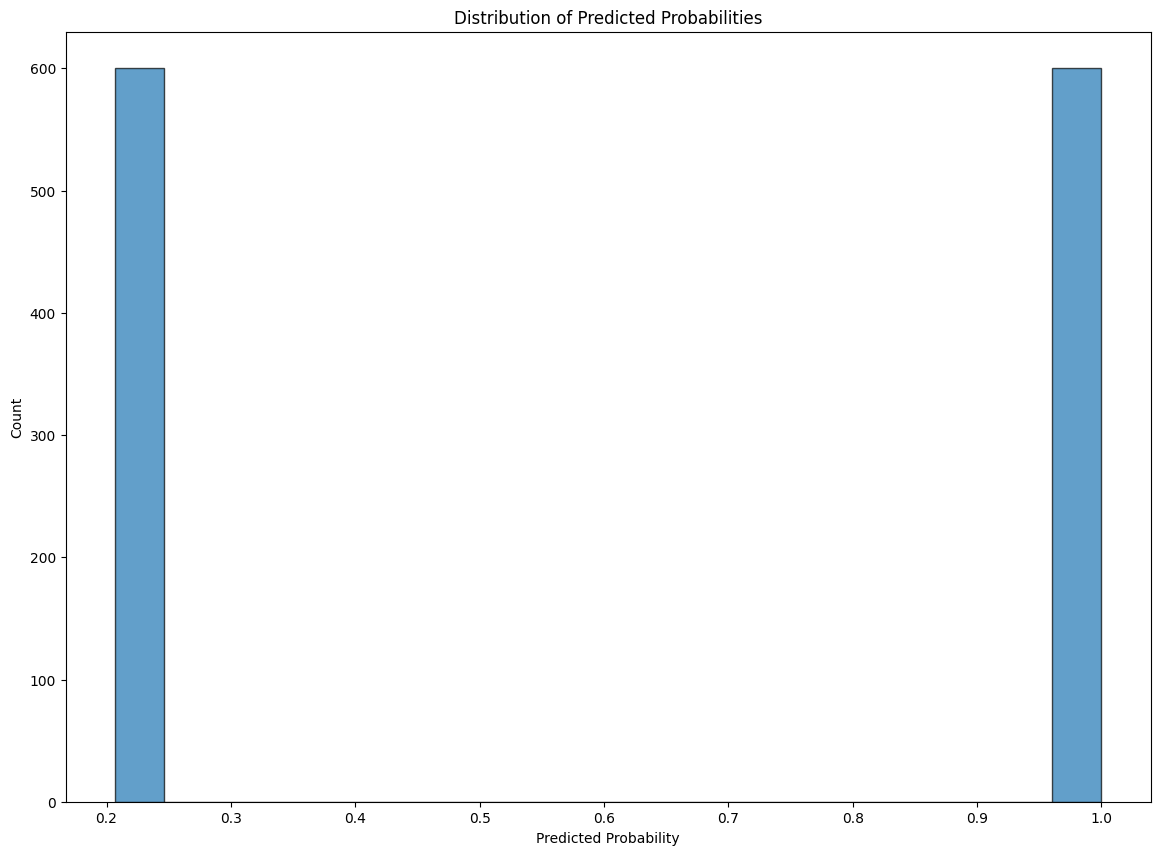

Area Under the Curve (AUC): 1.0000

Classification Report:              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       600
         1.0       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



NameError: name 'plot_learning_curve' is not defined

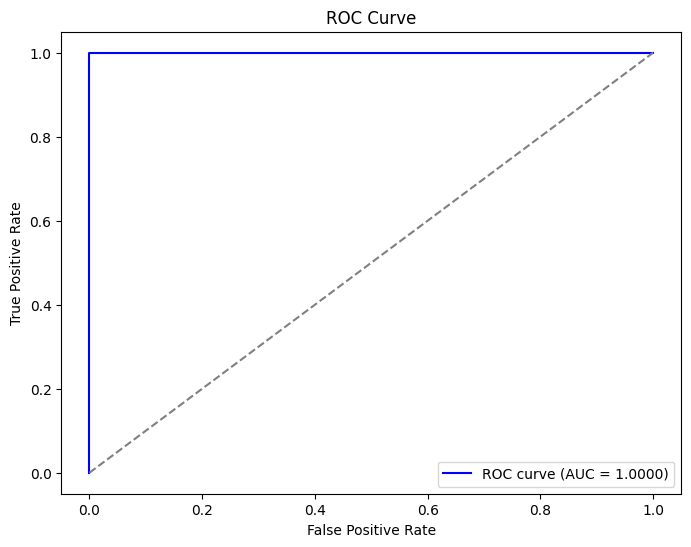

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model.predict(x_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

# Save plots
os.makedirs(save_path, exist_ok=True)

# Histogram of predictions
plt.figure(figsize=(14, 10))
plt.hist(predictions, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities")
plt.savefig(save_path + "histogram_predictions.png")
plt.show()

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig(save_path + "750_new_if_roc_curve.png")

print(f"Area Under the Curve (AUC): {roc_auc:.4f}")

# Classification report
report = classification_report(y_test, (predictions > 0.5).astype(int))
print("\nClassification Report:" + report)
report = classification_report(y_test, (predictions > 0.5).astype(int), output_dict=True)

# Convert the dictionary into a DataFrame and transpose it
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv("750_new_if_classification_report.csv")

# Plot learning curves
plot_learning_curve(rnn_fit, save_path="750_new_if_learning_curve")


In [ ]:
import shap
explainer = shap.Explainer(model, input_data)

# Calculate SHAP values for the input data
shap_values = explainer(input_data)






In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(shap_values[0], input_data[0]

In [ ]:
shap.dependence_plot("feature_name", shap_values, input_data)

In [ ]:
shap.waterfall_plot(shap_values[0])